In [20]:
import pandas as pd
from pathlib import Path
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize




In [21]:
CSV  = Path("data")


def load_data(root_path):
    data = []
    for dir in root_path.iterdir():
        if dir.is_dir():
            label = dir.name.strip() 
            for file_path in dir.glob("*.csv"):
                df = pd.read_csv(file_path)
                df['label'] = label
                data.append(df)
    return pd.concat(data, ignore_index=True)



In [22]:
raw_data = load_data(CSV)

In [23]:

print(f"Завантажені дані: {raw_data.shape}")
print(raw_data.sample(10))

Завантажені дані: (193860, 4)
        accelerometer_X  accelerometer_Y  accelerometer_Z    label
80123          0.033519       -11.391612        -3.323152  running
136398        -1.120486        -5.803545         2.044648   stairs
143805        -2.418144        -3.782838        -0.651223  walking
137503        -0.632069       -14.848839       -11.224017   stairs
2889           0.014365        -0.057461         9.734824     idle
10956          0.263362        -0.019154         9.753978     idle
114229         0.038307        12.200851         4.185065  running
125214         3.059790        13.206416        10.472239  running
126153        24.487894        28.797459         3.457227  running
54975         12.588713        25.823860        11.793838  running


In [24]:
class_distribution = raw_data['label'].value_counts().reset_index()
class_distribution.columns = ['class', 'count']

print(class_distribution)

     class   count
0  running  102240
1  walking   55500
2     idle   31170
3   stairs    4950


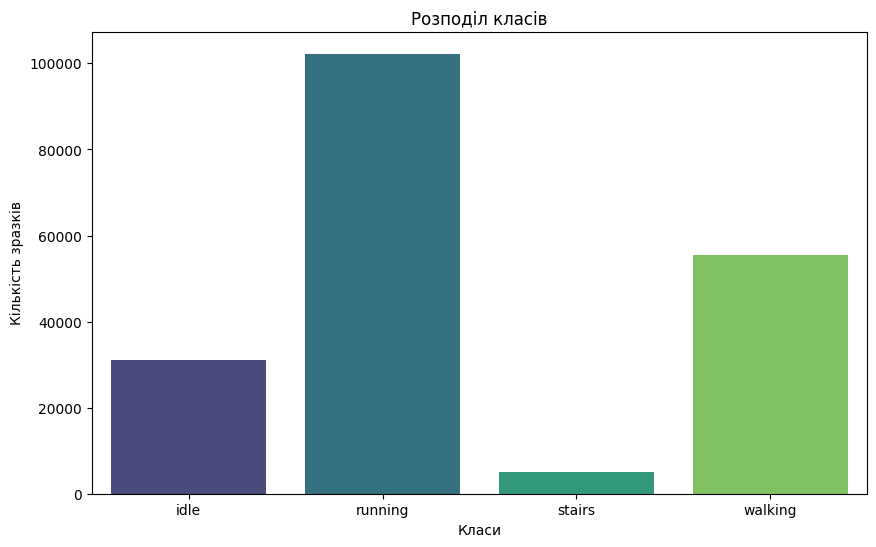

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=raw_data, hue='label', palette='viridis', dodge=False, legend=False)
plt.title('Розподіл класів')
plt.xlabel('Класи')
plt.ylabel('Кількість зразків')
plt.xticks(rotation=0)
plt.legend([],[], frameon=False)
plt.show()

In [26]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

SVM Accuracy: 0.7231774415405777
Random Forest Accuracy: 0.93707015130674

SVM Classification Report:
               precision    recall  f1-score   support

        idle       0.69      0.98      0.81       437
     running       0.98      0.70      0.82      1587
      stairs       0.08      0.62      0.14        69
     walking       0.84      0.64      0.73       815

    accuracy                           0.72      2908
   macro avg       0.65      0.74      0.62      2908
weighted avg       0.88      0.72      0.77      2908

Random Forest Classification Report:
               precision    recall  f1-score   support

        idle       0.98      0.99      0.98       437
     running       0.96      0.95      0.95      1587
      stairs       0.96      0.38      0.54        69
     walking       0.88      0.93      0.91       815

    accuracy                           0.94      2908
   macro avg       0.94      0.81      0.85      2908
weighted avg       0.94      0.94      0.93 

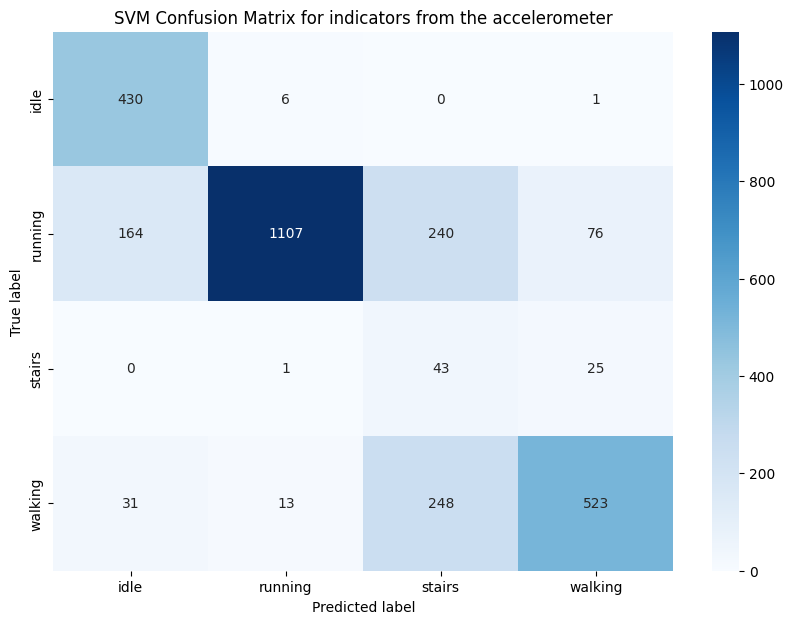

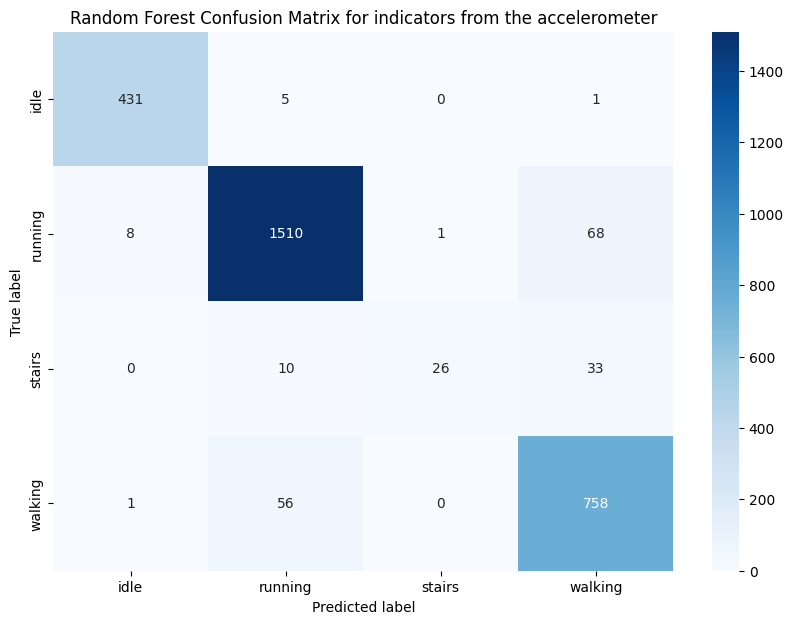

In [27]:
raw_data_sample = raw_data.sample(frac=0.05, random_state=42)

X = raw_data_sample.drop(columns=['label'])
y = raw_data_sample['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm, zero_division=0))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plot_confusion_matrix(cm_svm, classes=np.unique(y), title=f'SVM Confusion Matrix for indicators from the accelerometer')
plot_confusion_matrix(cm_rf, classes=np.unique(y), title=f'Random Forest Confusion Matrix for indicators from the accelerometer')

     

In [28]:
def compute_entropy(signal):
    epsilon = 1e-9
    signal_shifted = signal - signal.min() + epsilon  # Зсув значень сигналу
    probability_distribution = signal_shifted / np.sum(signal_shifted)
    entropy = -np.sum(probability_distribution * np.log2(probability_distribution))
    return entropy

In [29]:
def extract_time_domain_features(df, window_size=50, step_size=25):
    features = []

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = df.iloc[start:end]

        feature_dict = {}
        for axis in ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']:
            feature_dict[f'{axis}_mean'] = window[axis].mean()
            feature_dict[f'{axis}_var'] = window[axis].var()
            feature_dict[f'{axis}_std'] = window[axis].std()
            feature_dict[f'{axis}_median'] = window[axis].median()
            feature_dict[f'{axis}_min'] = window[axis].min()
            feature_dict[f'{axis}_max'] = window[axis].max()
            feature_dict[f'{axis}_range'] = window[axis].max() - window[axis].min()
            feature_dict[f'{axis}_rms'] = np.sqrt((window[axis]**2).mean())
            feature_dict[f'{axis}_sma'] = window[axis].abs().sum() / window_size
            feature_dict[f'{axis}_index_min'] = window[axis].idxmin()
            feature_dict[f'{axis}_index_max'] = window[axis].idxmax()
            feature_dict[f'{axis}_power'] = (window[axis]**2).sum()
            feature_dict[f'{axis}_energy'] = (window[axis]**2).mean()

            feature_dict[f'{axis}_entropy'] = compute_entropy(window[axis])

            feature_dict[f'{axis}_skewness'] = window[axis].skew()
            feature_dict[f'{axis}_kurtosis'] = window[axis].kurtosis()
            feature_dict[f'{axis}_iqr'] = window[axis].quantile(0.75) - window[axis].quantile(0.25)


        feature_dict['label'] = window['label'].mode()[0]

        features.append(feature_dict)

    return pd.DataFrame(features)

time_features = extract_time_domain_features(raw_data)
df_t = time_features
print(f"df_t shape: {df_t.shape}")

df_t shape: (7753, 52)


In [30]:
def plot_multiclass_roc(y_test, y_pred_prob, n_classes, title):
    
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2,
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})')
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [31]:
def plot_multiclass_precision_recall(y_test, y_pred_prob, n_classes, title):
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    average_precision["micro"] = average_precision_score(y_test_bin, y_pred_prob, average="micro")

    plt.figure()
    plt.plot(recall["micro"], precision["micro"], color='b', lw=2,
             label=f'micro-average Precision-Recall curve (AP = {average_precision["micro"]:.2f})')
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2,
                 label=f'Precision-Recall curve of class {i} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()
     

Indicators from the accelerometer
SVM Classification Report for Indicators from the accelerometer:
               precision    recall  f1-score   support

        idle       0.75      0.78      0.76       437
     running       0.87      0.84      0.86      1587
      stairs       0.00      0.00      0.00        69
     walking       0.76      0.85      0.80       815

    accuracy                           0.82      2908
   macro avg       0.59      0.62      0.61      2908
weighted avg       0.80      0.82      0.81      2908

Random Forest Classification Report for Indicators from the accelerometer:
               precision    recall  f1-score   support

        idle       0.98      0.99      0.99       437
     running       0.95      0.95      0.95      1587
      stairs       0.86      0.35      0.49        69
     walking       0.88      0.93      0.90       815

    accuracy                           0.93      2908
   macro avg       0.92      0.80      0.83      2908
weighted 

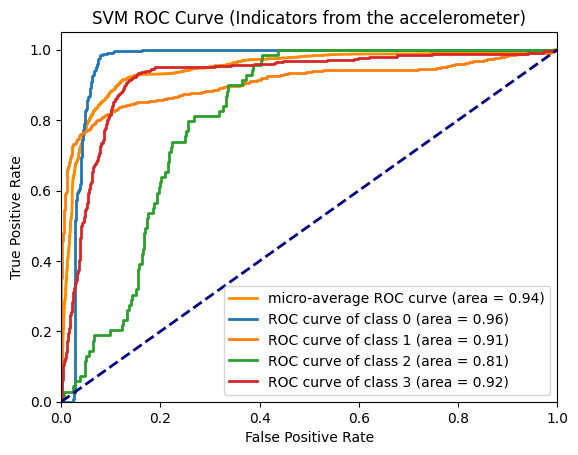

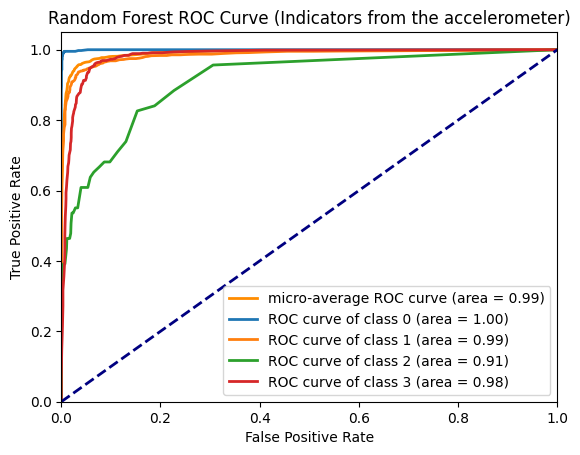

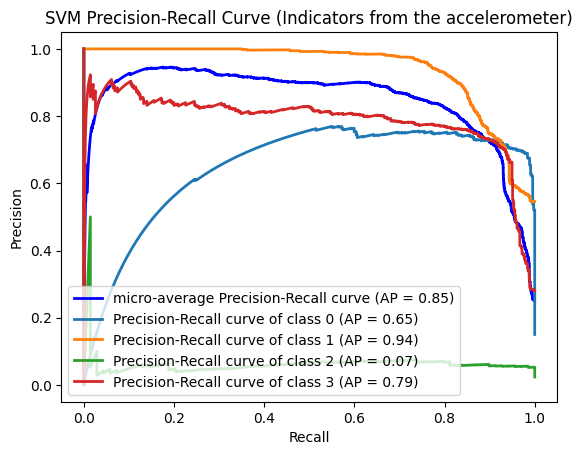

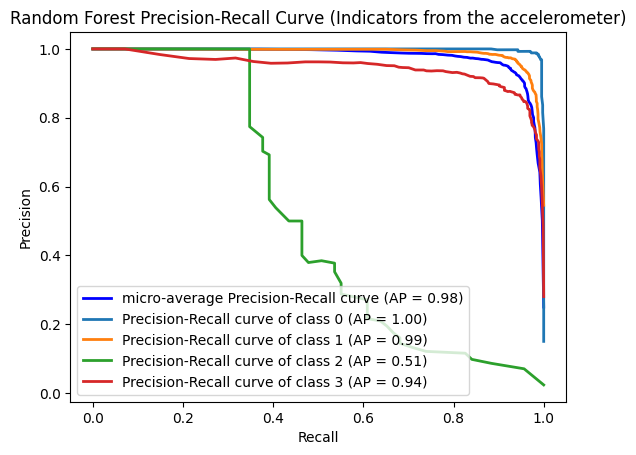

Time Domain Features
SVM Classification Report for Time Domain Features:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00       395
     running       1.00      1.00      1.00      1226
      stairs       1.00      1.00      1.00        54
     walking       1.00      1.00      1.00       651

    accuracy                           1.00      2326
   macro avg       1.00      1.00      1.00      2326
weighted avg       1.00      1.00      1.00      2326

Random Forest Classification Report for Time Domain Features:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00       395
     running       1.00      1.00      1.00      1226
      stairs       1.00      1.00      1.00        54
     walking       1.00      1.00      1.00       651

    accuracy                           1.00      2326
   macro avg       1.00      1.00      1.00      2326
weighted avg       1.00      1.00      1.00     

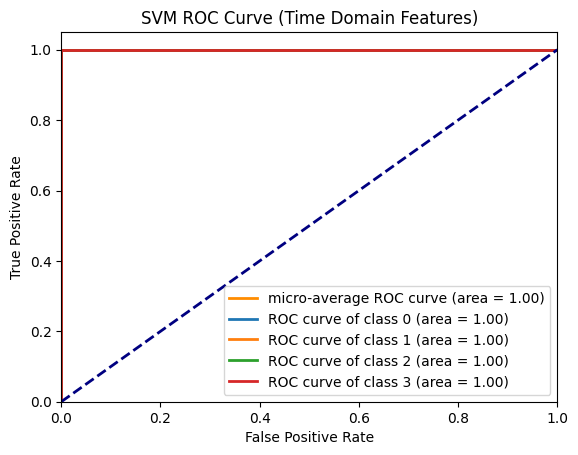

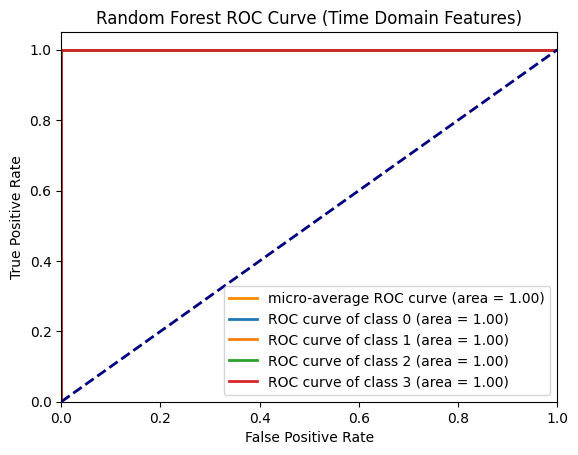

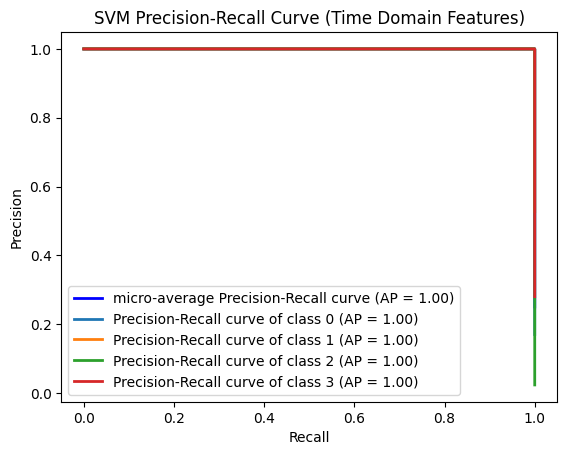

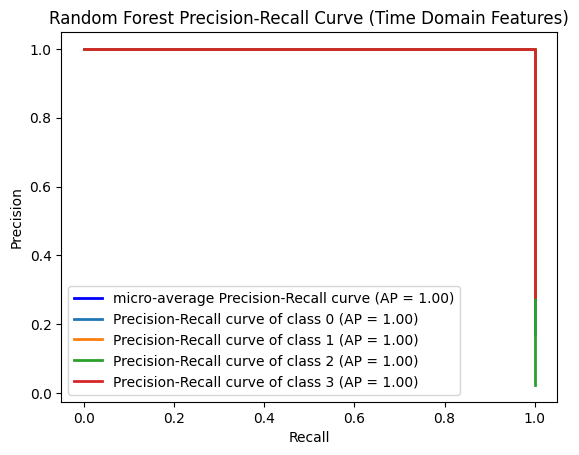

In [32]:
def train_and_evaluate_with_multiclass_plots(X, y, feature_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    n_classes = len(np.unique(y))

    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    y_pred_svm_prob = svm_model.predict_proba(X_test)

    rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_pred_rf_prob = rf_model.predict_proba(X_test)

    print(f"SVM Classification Report for {feature_name}:\n", classification_report(y_test, y_pred_svm, zero_division=0))
    print(f"Random Forest Classification Report for {feature_name}:\n", classification_report(y_test, y_pred_rf, zero_division=0))

    cm_svm = confusion_matrix(y_test, y_pred_svm)
    cm_rf = confusion_matrix(y_test, y_pred_rf)

    plot_multiclass_roc(y_test, y_pred_svm_prob, n_classes, f'SVM ROC Curve ({feature_name})')
    plot_multiclass_roc(y_test, y_pred_rf_prob, n_classes, f'Random Forest ROC Curve ({feature_name})')

    plot_multiclass_precision_recall(y_test, y_pred_svm_prob, n_classes, f'SVM Precision-Recall Curve ({feature_name})')
    plot_multiclass_precision_recall(y_test, y_pred_rf_prob, n_classes, f'Random Forest Precision-Recall Curve ({feature_name})')

raw_data_sample = raw_data.sample(frac=0.05, random_state=42)
X = raw_data_sample.drop(columns=['label'])
y = raw_data_sample['label']

X_time = time_features.drop(columns=['label'])
y_time = time_features['label']

print("Indicators from the accelerometer")
train_and_evaluate_with_multiclass_plots(X, y, 'Indicators from the accelerometer')

print("Time Domain Features")
train_and_evaluate_with_multiclass_plots(X_time, y_time, 'Time Domain Features')